get corpus from https://www.manythings.org/anki/ 

In [1]:
import os

input_lang = "eng"
target_lang = "spa"

if os.path.isfile(f"{input_lang}-{target_lang}.txt"):
    filepath = f"{input_lang}-{target_lang}.txt"
    reverse = False
elif os.path.isfile(f"{target_lang}-{input_lang}.txt"):
    filepath = f"{target_lang}-{input_lang}.txt"
    reverse = True
else:
    raise FileNotFoundError("Missing training set for specified language pair")

In [2]:
from torchtext.data.utils import get_tokenizer
import re
import contractions

tokenizer_eng = get_tokenizer("spacy", language="en_core_web_sm")
tokenizer_spa = get_tokenizer("spacy", language="es_core_news_sm")


def tokenize(text, lang=None):
    if lang == "eng":
        text = contractions.fix(text)
        tokenizer = tokenizer_eng
    elif lang == "spa":
        tokenizer = tokenizer_spa
    else:
        raise NotImplementedError("Missing tokenizer for specified language ")

    standardized_text = (
        text.replace("’", "'")
        .replace("‘", "'")
        .replace("´", "'")
        .replace("“", '"')
        .replace("”", '"')
        .replace("´´", '"')
    )
    tokens = tokenizer(standardized_text)
    filtered_tokens = [
        token
        for token in tokens
        if re.match(
            r"^[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+(-[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+)*(_[a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ.,!?¡¿]+)*$",
            token,
        )
    ]
    return filtered_tokens


#
#
#


# Example usage:
text_eng = "I'm building a translator!"
text_spa = "¡Estoy construyendo un traductor!"
print(tokenize(text_eng, lang="eng"))
print(tokenize(text_spa, lang="spa"))

['I', 'am', 'building', 'a', 'translator', '!']
['¡', 'Estoy', 'construyendo', 'un', 'traductor', '!']


define vocabularies from corpu as defined in next chapter

In [3]:
def corpus_iterator(filepath, lang, reverse):
    with open(filepath, "r", encoding="utf-8") as file:

        for line in file:

            elems = line.strip().split("\t")
            selected_text = elems[1 if reverse else 0]

            yield tokenize(selected_text, lang)

In [4]:
from torchtext.vocab import build_vocab_from_iterator


def build_vocab(filepath, lang, reverse, specials="<unk>", min_freq=5):
    vocab = build_vocab_from_iterator(
        corpus_iterator(filepath, lang, reverse),
        min_freq=min_freq,
        specials=specials,
    )
    vocab.set_default_index(vocab[specials[-1]])
    return vocab


special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]

vocab_input = build_vocab(filepath, input_lang, reverse, special_tokens)
vocab_target = build_vocab(filepath, target_lang, not reverse, special_tokens)

In [5]:
vocab_input.__len__()

6082

In [6]:
vocab_input.lookup_token(120)

'some'

process data 

In [7]:
import numpy as np


def all_words_in_vocab(sentence, vocab):
    return all(word in vocab for word in sentence)


def pad_sentence(sequence, max_length=10):
    padding_length = max_length - len(sequence)
    return ["<sos>"] + sequence + ["<eos>"] + ["<pad>"] * padding_length


def process_corpus(
    lines,
    reverse,
    input_lang,
    target_lang,
    vocab_input,
    vocab_target,
    max_length=10,
):
    processed_inputs, processed_targets = [], []

    for line in lines:
        elems = line.strip().split("\t")

        input_seq = tokenize(elems[int(reverse)], input_lang)
        target_seq = tokenize(elems[int(not reverse)], target_lang)

        if (
            all_words_in_vocab(input_seq, vocab_input)
            and all_words_in_vocab(target_seq, vocab_target)
            and len(input_seq) <= max_length
            and len(target_seq) <= max_length
        ):
            padded_input = pad_sentence(input_seq)
            padded_target = pad_sentence(target_seq)

            processed_inputs.append(vocab_input(padded_input))
            processed_targets.append(vocab_target(padded_target))

    return np.array(processed_inputs), np.array(processed_targets)


with open(filepath, "r", encoding="utf-8") as file:
    inputs, targets = process_corpus(
        file, reverse, input_lang, target_lang, vocab_input, vocab_target
    )

datasets, dataloader

In [8]:
import deeptrack as dt
import torch

sources = dt.sources.Source(inputs=inputs, targets=targets)
train_sources, test_sources = dt.sources.random_split(sources, [0.85, 0.15])

inputs_pl = dt.Value(sources.inputs) >> dt.pytorch.ToTensor(dtype=torch.int)
targets_pl = dt.Value(sources.targets) >> dt.pytorch.ToTensor(dtype=torch.int)


from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(
    inputs_pl & targets_pl,
    inputs=train_sources,
)
train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
)

test_dataset = dt.pytorch.Dataset(
    inputs_pl & targets_pl,
    inputs=test_sources,
)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [9]:
import numpy as np

print(f"Number of queries/responses: {len(inputs)}")

Number of queries/responses: 91183


In [10]:
# pairs = [[s, t] for (s, t) in zip(inputs, targets)]

# print([vocab_input.lookup_token(p) for p in pairs[1000][0]])
# print([vocab_target.lookup_token(p) for p in pairs[1000][1]])

embedding

deeplay modules

encoder

In [11]:
from deeplay import DeeplayModule
from typing import Optional, Union, Type, Literal
import torch


class Seq2SeqEncoder(DeeplayModule):

    def __init__(
        self,
        vocab_size: Optional[int],
        in_features: Optional[int] = 300,
        hidden_features: Optional[int] = 128,
        hidden_layers: Optional[int] = 1,
        dropout: Optional[float] = 0.0,
        rnn_type: Union[Literal["RNN", "LSTM", "GRU"], Type[torch.nn.Module]] = "GRU",
        bidirectional=True,
    ):
        super().__init__()
        if isinstance(rnn_type, type) and issubclass(rnn_type, torch.nn.Module):
            self.rnn_class = rnn_type
        elif rnn_type == "LSTM":
            self.rnn_class = torch.nn.LSTM
        elif rnn_type == "GRU":
            self.rnn_class = torch.nn.GRU
        else:
            self.rnn_class = torch.nn.RNN

        self.hidden_features = hidden_features
        self.hidden_layers = hidden_layers
        self.bidirectional = bidirectional
        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_features)
        self.rnn = dl.Layer(
            self.rnn_class,
            input_size=in_features,
            hidden_size=hidden_features,
            num_layers=hidden_layers,
            dropout=(0 if hidden_layers == 1 else dropout),
            bidirectional=bidirectional,
            batch_first=True,
        )

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        outputs, hidden = self.rnn(x, hidden)
        if self.bidirectional:
            outputs = (
                outputs[:, :, : self.hidden_features]
                + outputs[:, :, self.hidden_features :]
            )
            hidden = hidden[: self.hidden_layers]
        return outputs, hidden

decoder

In [12]:
# no attn


class Seq2SeqDecoder(DeeplayModule):

    def __init__(
        self,
        vocab_size: Optional[int],
        in_features: Optional[int] = 300,
        hidden_features: Optional[int] = 128,
        hidden_layers: Optional[int] = 1,
        dropout: Optional[float] = 0.0,
        rnn_type: Union[Literal["RNN", "LSTM", "GRU"], Type[torch.nn.Module]] = "GRU",
    ):
        super().__init__()
        if isinstance(rnn_type, type) and issubclass(rnn_type, torch.nn.Module):
            self.rnn_class = rnn_type
        elif rnn_type == "LSTM":
            self.rnn_class = torch.nn.LSTM
        elif rnn_type == "GRU":
            self.rnn_class = torch.nn.GRU
        else:
            self.rnn_class = torch.nn.RNN

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_layers = hidden_layers
        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_features)
        self.rnn = dl.Layer(
            self.rnn_class,
            input_size=in_features,
            hidden_size=hidden_features,
            num_layers=hidden_layers,
            bidirectional=False,
            batch_first=True,
            dropout=(0 if hidden_layers == 1 else dropout),
        )
        self.dense = dl.Layer(torch.nn.Linear, hidden_features, vocab_size)
        self.softmax = dl.Layer(torch.nn.Softmax, dim=-1)
        self.relu = dl.Layer(torch.nn.ReLU)

    def forward(self, x, hidden):
        x = self.embedding(x)
        x = self.relu(x)
        output, hidden = self.rnn(x, hidden)
        output = self.dense(output)
        output = self.softmax(output)
        return output, hidden

seq2seq

In [13]:
# no attn


class Seq2SeqModel(DeeplayModule):

    def __init__(
        self,
        in_vocab_size: Optional[int] = None,
        out_vocab_size: Optional[int] = None,
        teacher_prob=1.0,
        embedding_dim: Optional[int] = 300,
        hidden_features: Optional[int] = 128,
        hidden_layers: Optional[int] = 1,
        dropout: Optional[float] = 0.0,
        rnn_type: Union[Literal["RNN", "LSTM", "GRU"], Type[torch.nn.Module]] = "GRU",
        bidirectional=True,
    ):
        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.teacher_prob = teacher_prob
        self.encoder = Seq2SeqEncoder(
            in_vocab_size,
            embedding_dim,
            hidden_features,
            hidden_layers,
            dropout,
            rnn_type,
            bidirectional,
        )
        self.decoder = Seq2SeqDecoder(
            out_vocab_size,
            embedding_dim,
            hidden_features,
            hidden_layers,
            dropout,
            rnn_type,
        )

    def forward(self, x):
        input, target = x
        encoder_outputs, encoder_hidden = self.encoder(input)
        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(
            (
                target.size(0),
                target.size(1),
                self.out_vocab_size,
            )
        ).to(next(self.encoder.parameters()).device)

        for t in range(input.size(1)):
            if t == 0 or np.random.rand() < self.teacher_prob:
                decoder_input = target[:, t].unsqueeze(-1)
            else:
                decoder_input = topi.squeeze(-1).detach()

            decoder_input = decoder_input.to(next(self.decoder.parameters()).device)

            decoder_output, decoder_hidden = self.decoder(
                decoder_input,
                decoder_hidden,
            )

            _, topi = decoder_output.topk(1)
            decoder_outputs[:, t, :] = decoder_output.squeeze(1)

        return decoder_outputs

    def evaluate(self, x):
        if isinstance(x, (list, tuple)):
            input = x[0]
        else:
            input = x

        with torch.no_grad():
            encoder_outputs, encoder_hidden = self.encoder(input)
        decoder_hidden = encoder_hidden
        outputs = torch.zeros(
            input.shape,
        ).to(next(self.encoder.parameters()).device)
        for t in range(input.size(1)):
            if t == 0:
                decoder_input = torch.full(
                    size=(input.size(0), 1),
                    fill_value=1,  # self.vocab_input(["<sos>"]),
                    device=next(self.encoder.parameters()).device,
                )
            else:
                decoder_input = topi.squeeze(-1).detach()

            decoder_input = decoder_input.to(next(self.decoder.parameters()).device)
            with torch.no_grad():
                decoder_output, decoder_hidden = self.decoder(
                    decoder_input,
                    decoder_hidden,
                )
            _, topi = decoder_output.topk(1)
            outputs[:, t] = topi.squeeze()

        return outputs

In [14]:
def maskedNLL(inp, target, PADtoken=0):
    mask = target != PADtoken
    NLL = -torch.log(torch.gather(inp.view(-1, inp.shape[-1]), 1, target.view(-1, 1)))
    loss = NLL.masked_select(mask.view(-1, 1)).mean()
    return loss

In [15]:
from deeplay import Application, Optimizer
from typing import Sequence
from torchtext import vocab
import torchmetrics as tm


class Seq2Seq(Application):
    in_vocab: vocab
    out_vocab: vocab
    teacher_prob: float
    model: torch.nn.Module
    loss: torch.nn.Module
    optimizer: Optimizer
    loss: torch.nn.Module

    def __init__(
        self,
        in_vocab,
        out_vocab,
        teacher_prob=1.0,
        model=None,
        optimizer=None,
        loss=None,
    ):

        in_vocab_size = len(in_vocab)
        out_vocab_size = len(out_vocab)

        self.model = model or Seq2SeqModel(
            in_vocab_size=in_vocab_size,
            out_vocab_size=out_vocab_size,
            teacher_prob=teacher_prob,
        )

        self.in_vocab_size = in_vocab_size
        self.out_vocab_size = out_vocab_size
        self.teacher_prob = teacher_prob
        self.optimizer = optimizer or dl.Adam(lr=1e-3)
        self.loss = loss or maskedNLL
        self.out_vocab = out_vocab

        @self.optimizer.params
        def params(self):
            return self.parameters()

        super().__init__(loss=loss)

    def train_preprocess(self, batch):
        x = batch
        y = torch.cat((x[-1][:, 1:], x[-1][:, -1:]), dim=1)
        return x, y

    val_preprocess = train_preprocess
    test_preprocess = train_preprocess

    def forward(self, x):
        decoder_outputs = self.model(x)

        return decoder_outputs

In [16]:
# import torch

# The dimensionality of GloVe embeddings
embedding_dim = 300

from torchtext.vocab import GloVe

# Load GloVe embeddings
glove = GloVe(name="42B", dim=embedding_dim, cache="./.vector_cache")

# Get GloVe embeddings for the vocabulary tokens
# Assuming 'vocab' is a list of vocabulary tokens including special tokens at the beginning
glove_embeddings_input = glove.get_vecs_by_tokens(
    vocab_input.get_itos(), lower_case_backup=True
)
glove_embeddings_target = glove.get_vecs_by_tokens(
    vocab_target.get_itos(), lower_case_backup=True
)

num_special_tokens = len(special_tokens)
glove_embeddings_input[1:num_special_tokens] = (
    torch.rand(num_special_tokens - 1, embedding_dim) * 0.01
)  # Small random numbers for SOS, EOS

glove_embeddings_target[1:num_special_tokens] = (
    torch.rand(num_special_tokens - 1, embedding_dim) * 0.01
)  # Small random numbers for SOS, EOS

INFO:torchtext.vocab.vectors:Loading vectors from ./.vector_cache/glove.42B.300d.txt.pt


In [17]:
import deeplay as dl

seq2seq = Seq2Seq(
    in_vocab=vocab_input,
    out_vocab=vocab_target,
    teacher_prob=0.85,
)

seq2seq = seq2seq.create()

In [18]:
# # Initialize a tensor to hold the embeddings for special tokens
# # Here, PAD is initialized to zeros and SOS, EOS to random values
# special_embeddings = torch.zeros(num_special_tokens, embedding_dim)
# special_embeddings[1:] = (
#     torch.rand(num_special_tokens - 1, embedding_dim) * 0.01
# )  # Small random numbers for SOS, EOS


# # Concatenate the special token embeddings with the GloVe embeddings
# extended_embeddings_input = torch.cat(
#     [special_embeddings, glove_embeddings_input], dim=0
# )
# extended_embeddings_target = torch.cat(
#     [special_embeddings, glove_embeddings_target], dim=0
# )


seq2seq.model.encoder.embedding.weight.data = glove_embeddings_input
seq2seq.model.encoder.embedding.weight.requires_grad = False
seq2seq.model.decoder.embedding.weight.data = glove_embeddings_target
seq2seq.model.decoder.embedding.weight.requires_grad = False

In [19]:
trainer = dl.Trainer(max_epochs=25, accelerator="mps")
trainer.fit(seq2seq, train_loader)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-05-10 17:15:02.623427: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model         │ Seq2SeqModel     │  6.3 M │
│ 1 │ out_vocab     │ Vocab            │      0 │
│ 2 │ train_metrics │ MetricCollection │      0 │
│ 3 │ val_metrics   │ MetricCollection │      0 │
│ 4 │ test_metrics  │ MetricCollection │      0 │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 4.6 M                                                                                        
Total params: 6.3 M                                                                                                
Total estimated model params size (MB): 25

Output()

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


(<Figure size 1500x500 with 1 Axes>,
 array([[<Axes: title={'center': 'Loss'}, xlabel='Step'>]], dtype=object))

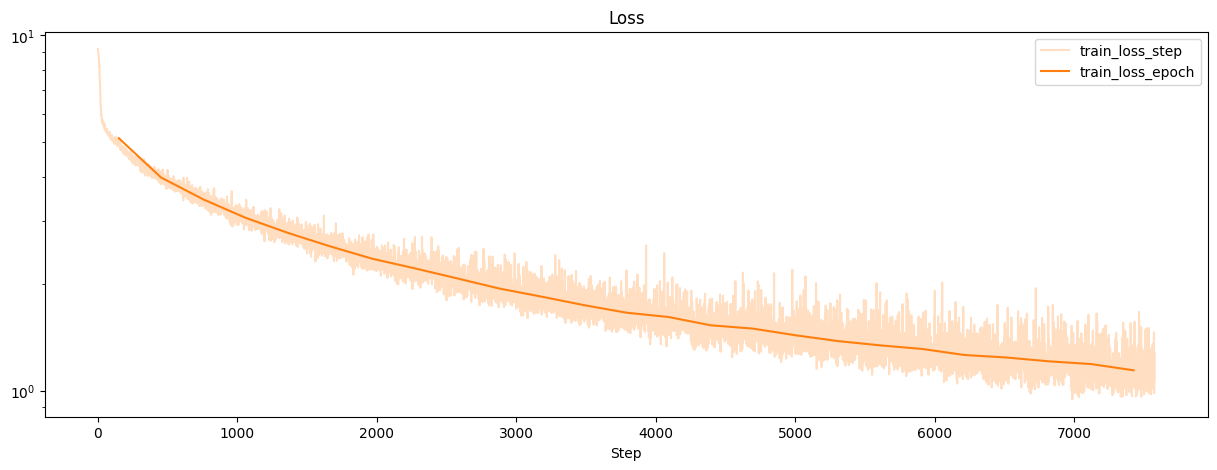

In [20]:
trainer.history.plot()

evaluate results

In [21]:
from torchmetrics.text import BLEUScore

bleu_score = BLEUScore()

In [22]:
def unprocess(x, vocab):
    unproc = []
    for s in x:
        idxs = s[s > 2]
        current_words = [vocab.lookup_token(idx) for idx in idxs]
        unproc.append(" ".join(current_words))

    return unproc

calculate BLEU score

In [23]:
device = "cpu"
seq2seq.model.to(device)
# device = next(seq2seq.model.parameters()).device

for batch_index, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    y_hat = seq2seq.model.evaluate((inputs, targets))

    input_un = unprocess(inputs, vocab_input)
    y_hat_un = unprocess(y_hat, vocab_target)
    target_un = unprocess(targets, vocab_target)
    y = [[yi] for yi in target_un]

    bleu_score.update(y_hat_un, y)

    if batch_index < 3:
        print(f"\nExamples from batch {batch_index + 1}:")
        for i in range(min(3, len(input_un))):
            print(f"\nInput Sentence: {input_un[i]}")
            print(f"Predicted Translation: {y_hat_un[i]}")
            print(f"Actual Translation: {target_un[i]}")

final_bleu = bleu_score.compute()
print(f"Validation BLEU Score: {final_bleu:.3f}")


Examples from batch 1:

Input Sentence: I am pretty interested in it .
Predicted Translation: Estoy bastante interesado en esto .
Actual Translation: Estoy muy interesado en eso .

Input Sentence: We did not do it .
Predicted Translation: No lo hicimos .
Actual Translation: Nosotros no lo hicimos .

Input Sentence: pay .
Predicted Translation: Escoge . .
Actual Translation: Tom pagará .

Examples from batch 2:

Input Sentence: Mary is wearing a silver ring .
Predicted Translation: Mary lleva puesto un anillo de madera .
Actual Translation: María lleva puesto un anillo de plata .

Input Sentence: Tom seems to believe everything Mary says .
Predicted Translation: Tom cree que todo lo que dice Mary .
Actual Translation: Parece que Tom cree todo lo que dice Mary .

Input Sentence: You do not want to go there .
Predicted Translation: No debes ir allí .
Actual Translation: No queréis ir allí .

Examples from batch 3:

Input Sentence: I do not know what it is .
Predicted Translation: No sé l

try on a few new sentences

In [24]:
def translate(
    source_text="This is an example.",
    model=seq2seq.model,
    input_lang=input_lang,
    vocab_input=vocab_input,
    vocab_target=vocab_target,
):
    query_tokens = tokenize(source_text, input_lang)
    query_tokens = pad_sentence(query_tokens)
    query_indices = vocab_input(query_tokens)
    if 3 in query_indices:
        print(
            "Warning: Unknown word(s) found in the input text. They were replaced by the placeholder token."
        )

    source_sequence = torch.tensor(query_indices, dtype=torch.int).unsqueeze(0)

    source_sequence = source_sequence.to(next(model.parameters()).device)
    y_hat = model.evaluate(source_sequence)

    translated_text = unprocess(y_hat, vocab_target)
    print(f"\nInput Sentence: {source_text}")
    print(f"Predicted Translation: {translated_text[0]}")
    # return translated_text[0]

In [25]:
source_text = "should we go?"
translate(source_text)


Input Sentence: should we go?
Predicted Translation: ¿ Podemos ir ?


In [27]:
source_text = "what's your name?"  # "¿como te llamas?"  #
translate(source_text)


Input Sentence: what's your name?
Predicted Translation: ¿ Cómo se llama ?


In [29]:
source_text = "Don't you have surname?"
translate(source_text)


Input Sentence: Don't you have surname?
Predicted Translation: ¿ No tienes ? ?


In [31]:
source_text = "How are you doing?"
translate(source_text)


Input Sentence: How are you doing?
Predicted Translation: ¿ Cómo estás haciendo ?


In [32]:
source_text = "I'm doing great too."
translate(source_text)


Input Sentence: I'm doing great too.
Predicted Translation: Me estoy muy bien .


In [33]:
source_text = "are you still happy?"
translate(source_text)


Input Sentence: are you still happy?
Predicted Translation: ¿ Todavía estás feliz ?


In [34]:
source_text = "who is the american president?"
translate(source_text)


Input Sentence: who is the american president?
Predicted Translation: ¿ Quién es la embajada ? ?


In [35]:
source_text = "Are you messing around with me?"
translate(source_text)


Input Sentence: Are you messing around with me?
Predicted Translation: ¿ Estás con con conmigo ?


In [36]:
source_text = "why don't you stop laughing at me?"
translate(source_text)


Input Sentence: why don't you stop laughing at me?
Predicted Translation: ¿ Por qué no te rías de reír ?


In [37]:
source_text = "I would like a glass of wine"
translate(source_text)


Input Sentence: I would like a glass of wine
Predicted Translation: Quisiera una cerveza .
